### Name : Rutwik Jayant Deokar

# CS-632L Intro to Deep Learning Project :

# Detecting Cancer metastases on gigapixel pathology images

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 0s (949 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack .

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf

In [0]:
# Download an example slide and tumor mask
# Note: these are hosted on Google Cloud Storage.
# The remainder are in a Google Drive folder, linked above.

slide_path = 'tumor_091.tif'
tumor_mask_path = 'tumor_091_mask.tif'

slide_url = 'https://storage.googleapis.com/applied-dl/%s' % slide_path
mask_url = 'https://storage.googleapis.com/applied-dl/%s' % tumor_mask_path

# Download the whole slide image
if not os.path.exists(slide_path):
  !curl -O $slide_url

# Download the tumor mask
if not os.path.exists(tumor_mask_path):
  !curl -O $mask_url

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0  67.1M      0  0:00:07  0:00:07 --:--:-- 83.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  24.0M      0 --:--:-- --:--:-- --:--:-- 24.0M


In [0]:
slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read tumor mask from tumor_091_mask.tif
('Slide includes %d levels', 8)
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

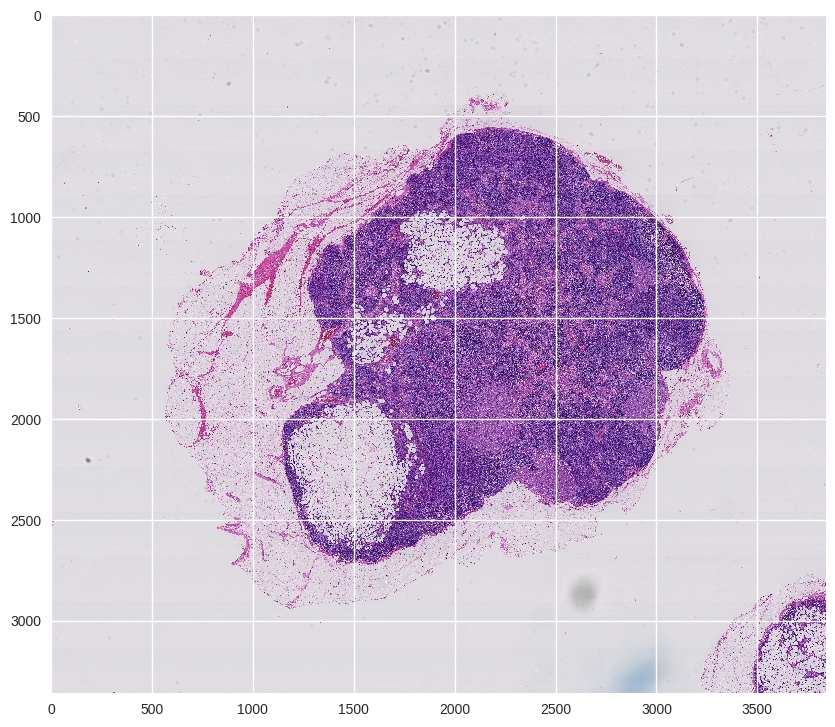

In [0]:
# Example: read the entire slide at level 5

# High zoom levels may not fit into memory.
# That's why we use OpenSlide. You can use the below function
# to extract regions from high zoom levels without having to 
# read the entire image.

# Note: this is just for demo purposes. 

# Use the sliding window approach discussed in class to collect training
# data for your classifier. E.g., slide a window across the slide (for
# starters, use a zoomed out view, so you're not working with giant images).
# Save each window to disk as an image. To find the label for that image, 
# check to see if same region on the mask image contains cancerous cells.

# Important: this is tricky to get right. Carefully debug your pipeline before
# training your model. Start with just a single image, and a relatively 
# low zoom level.

my_zoom_level = 4


slide_image_test = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=my_zoom_level, 
                         width=slide.level_dimensions[my_zoom_level][0], 
                         height=slide.level_dimensions[my_zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_test)

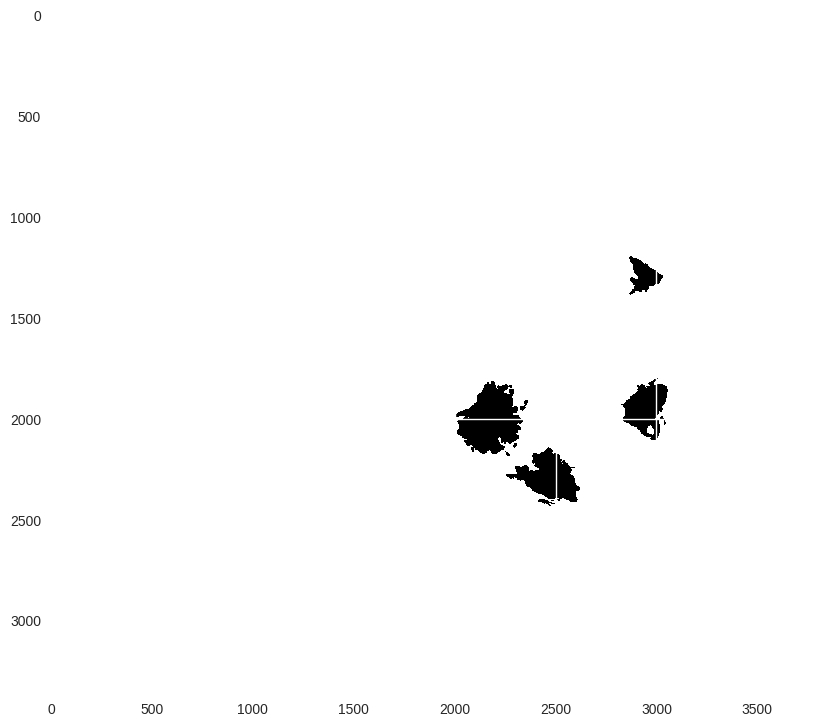

In [0]:
# Example: read the entire mask at the same zoom level
mask_image_test = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=my_zoom_level, 
                        width=slide.level_dimensions[my_zoom_level][0], 
                        height=slide.level_dimensions[my_zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image_test = mask_image_test[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image_test)

## Downloading a new Image to train on from Google Drive :

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


mask_id_3 = "1tWqfPOTNUx1XKKn-dNflXbAagvAR1VJd"
image_id_3 = "1rP3pEkmFd_95CO5dll9q6wK_yYQYFv2J"

image_file_3 = drive.CreateFile({'id': image_id_3})
mask_file_3 = drive.CreateFile({'id': mask_id_3})

image_file_3.GetContentFile("tumor_110.tif")
mask_file_3.GetContentFile("tumor_110_mask.tif")


# file_id = 'REPLACE_WITH_YOUR_FILE_ID'
# downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
slide_path = "tumor_110.tif"
tumor_mask_path = "tumor_110_mask.tif"

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
    assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif
('Slide includes %d levels', 9)
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dimensions: (736, 560) downsample factor 128
Level 8, dimensions: (368, 280) downsample factor 256


Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif


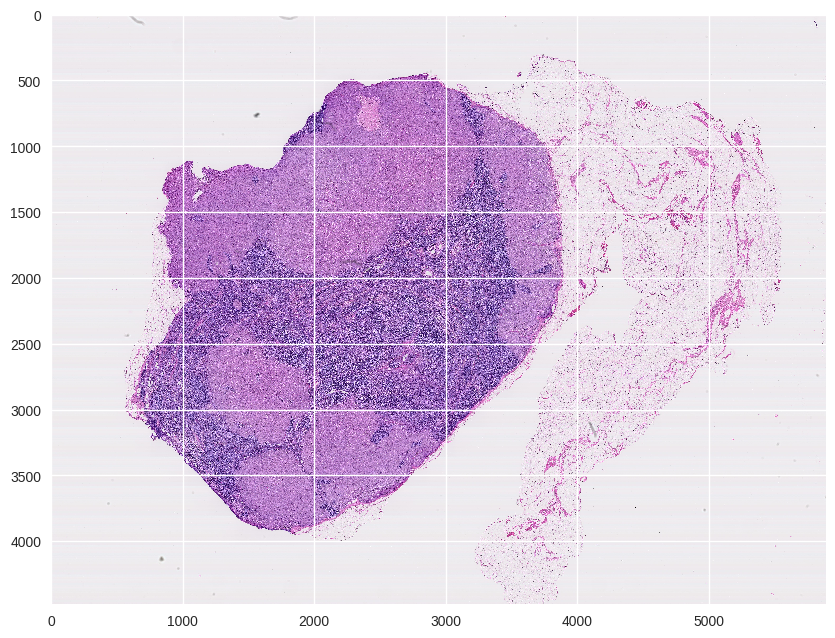

In [0]:
slide_path = 'tumor_110.tif'
tumor_mask_path = 'tumor_110_mask.tif'

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))



slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=my_zoom_level, 
                         width=slide.level_dimensions[my_zoom_level][0], 
                         height=slide.level_dimensions[my_zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

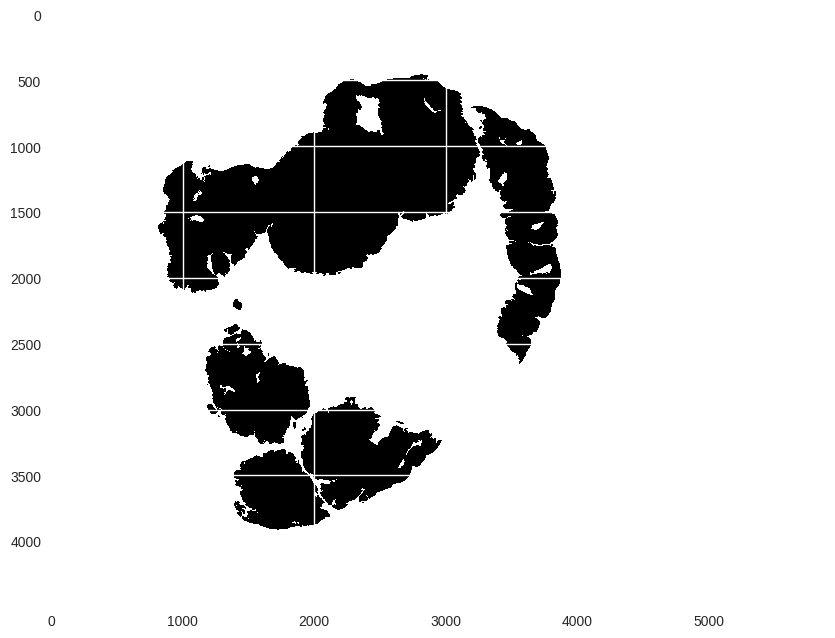

In [0]:
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=my_zoom_level, 
                        width=slide.level_dimensions[my_zoom_level][0], 
                        height=slide.level_dimensions[my_zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image = mask_image[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

## Split the Big Tif file into smaller images and labelling each new image using the Mask :


In [0]:

def split_img(slide_image,mask_image):

  split_size = 100
  splitted_images = []
  split_labels = []


  for i in range(0 , slide_image.shape[0] - split_size + 1, split_size):
    for j in range(0 , slide_image.shape[1] - split_size + 1 , split_size):
      slide_image_splitted = slide_image[i:i + split_size,j : j + split_size,:]
      splitted_images.append(slide_image_splitted)
      split_label = mask_image[i:i+split_size,j : j + split_size].sum()
      if split_label > 0:
        split_labels.append(1)
      else:
        split_labels.append(0)


  splitted_images = np.asarray(splitted_images)
  split_labels = np.asarray(split_labels)
  return splitted_images , split_labels

In [0]:
X_train , y_train = split_img(slide_image, mask_image)
print(X_train.shape)
print(y_train.shape)

(2552, 100, 100, 3)
(2552,)


### Doing the same for the Test Data or Test Image :


In [0]:
# Doing the same for the Test Data or Test Image :

X_test , y_test = split_img(slide_image_test, mask_image_test)


print(X_test.shape)

print(y_test.shape)

(1254, 100, 100, 3)
(1254,)


### Counting number of Normal and Cancerous in Training Set :



In [0]:

one_counter = 0
zero_counter = 0



for i in range(0, y_train.shape[0]):
  if y_train[i] == 0:
    zero_counter += 1
  else:
    one_counter += 1
    
    
print(" Number of Ones = ", one_counter)
print(" Number of Zeroes = ", zero_counter)

(' Number of Ones = ', 559)
(' Number of Zeroes = ', 1993)


### Counting number of Normal and Cancerous in Test Set :




In [0]:
# Counting number of label values in Test Set to check imbalance:

one_counter = 0
zero_counter = 0



for i in range(0, y_test.shape[0]):
  if y_test[i] == 0:
    zero_counter += 1
  else:
    one_counter += 1
    
    
print(" Number of Ones = ", one_counter)
print(" Number of Zeroes = ", zero_counter)

(' Number of Ones = ', 47)
(' Number of Zeroes = ', 1207)


### My CNN model with VGG as the Conv Base :



In [0]:
# from keras.applications import VGG16

conv_base = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(100, 100, 3))

conv_base.trainable = False



model = 0

model = tf.keras.Sequential([conv_base, 
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(10, activation='relu'),
#                             tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')])




model.compile(loss='binary_crossentropy',
              optimizer = tf.train.AdamOptimizer(),
              metrics=['acc'])

58900480/58889256 [==============================] - 6s 0us/step


In [0]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                46090     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 14,760,789
Trainable params: 46,101
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 2041 samples, validate on 511 samples
Epoch 1/10
2041/2041 [==============================] - 12s 6ms/step - loss: 0.6100 - acc: 0.8672 - val_loss: 0.1147 - val_acc: 0.9667
Epoch 2/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1903 - acc: 0.9162 - val_loss: 0.1491 - val_acc: 0.9589
Epoch 3/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1543 - acc: 0.9226 - val_loss: 0.1368 - val_acc: 0.9706
Epoch 4/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.1095 - acc: 0.9456 - val_loss: 0.1304 - val_acc: 0.9785
Epoch 5/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.0931 - acc: 0.9584 - val_loss: 0.1435 - val_acc: 0.9785
Epoch 6/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.0724 - acc: 0.9672 - val_loss: 0.1505 - val_acc: 0.9746
Epoch 7/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.0551 - acc: 0.9799 - val_loss: 0.1885 - val_acc: 0.9706
Epoch 8/10
204

### Saving The Model :

In [0]:
model.save_weights("Vgg_model.h5")

In [0]:
ls

adc.json      tumor_091_mask.tif  tumor_110_mask.tif  Vgg_model.h5
sample_data/  tumor_091.tif       tumor_110.tif


### Making Predictions on Test Images:

In [0]:
y_pred = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)
y_pred_label = model.predict_classes(X_test)

In [0]:
from sklearn.metrics import accuracy_score

print("Accuracy = " , accuracy_score(y_test, y_pred_label, normalize=True))

('Accuracy = ', 0.9218500797448166)


### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1207
           1       0.13      0.19      0.16        47

   micro avg       0.92      0.92      0.92      1254
   macro avg       0.55      0.57      0.56      1254
weighted avg       0.94      0.92      0.93      1254



### Confusion Matrix :

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_label)


array([[1147,   60],
       [  38,    9]])

In [0]:
y_pred_prob.shape

(1254, 1)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


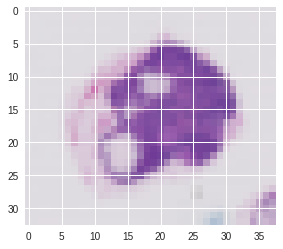

In [0]:
from scipy.misc import imresize

# from skimage.transform import resize
im_resize = imresize(slide_image_test, 0.01 , mode='RGB')
plt.imshow(im_resize)

### Generating Heatmap :

In [0]:
prob = np.reshape(y_pred_prob, (-1,38))


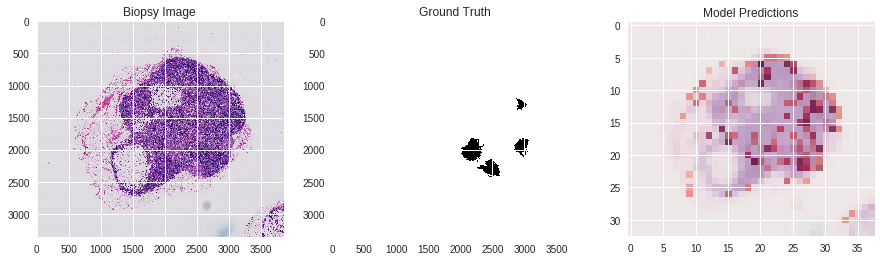

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(131 , title = "Biopsy Image")
plt.imshow(slide_image_test)
plt.subplot(132 , title = "Ground Truth")
plt.imshow(mask_image_test)
plt.subplot(133, title = "Model Predictions")
plt.imshow(im_resize)
plt.imshow(prob, cmap='Reds',alpha=0.5)
plt.show()


### My CNN model with Inceptionv3 as the Conv Base :



## Using Inception V3 :

In [0]:

conv_base = tf. keras.applications.inception_v3.InceptionV3(include_top=False, 
                                                            weights='imagenet',
                                                            input_shape=(100,100,3))


conv_base.trainable = False



model = 0

model = tf.keras.Sequential([conv_base, 
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')])




model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer = tf.train.AdamOptimizer(),
              metrics=['acc'])

87924736/87910968 [==============================] - 4s 0us/step


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 2041 samples, validate on 511 samples
Epoch 1/10
2041/2041 [==============================] - 10s 5ms/step - loss: 0.4805 - acc: 0.7722 - val_loss: 0.2698 - val_acc: 0.9041
Epoch 2/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3928 - acc: 0.8261 - val_loss: 0.1514 - val_acc: 0.9432
Epoch 3/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3812 - acc: 0.8329 - val_loss: 0.2219 - val_acc: 0.9335
Epoch 4/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3354 - acc: 0.8511 - val_loss: 0.2826 - val_acc: 0.9119
Epoch 5/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3300 - acc: 0.8550 - val_loss: 0.1811 - val_acc: 0.9335
Epoch 6/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3355 - acc: 0.8550 - val_loss: 0.1717 - val_acc: 0.9295
Epoch 7/10
2041/2041 [==============================] - 5s 2ms/step - loss: 0.3198 - acc: 0.8707 - val_loss: 0.1888 - val_acc: 0.9295
Epoch 8/10
204

In [0]:
y_pred = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)
y_pred_label = model.predict_classes(X_test)

In [0]:
from sklearn.metrics import accuracy_score

print("Accuracy = " , accuracy_score(y_test, y_pred_label, normalize=True))

('Accuracy = ', 0.8628389154704944)


### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      1207
           1       0.15      0.60      0.25        47

   micro avg       0.86      0.86      0.86      1254
   macro avg       0.57      0.73      0.59      1254
weighted avg       0.95      0.86      0.90      1254



### Confusion Matrix :

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_label)


array([[1054,  153],
       [  19,   28]])

In [0]:
y_pred_prob.shape

(1254, 1)

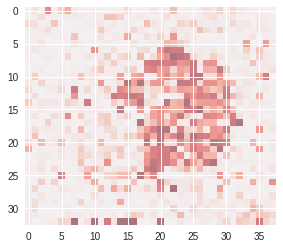

In [0]:
prob = np.reshape(y_pred_prob, (-1,38))
plt.imshow(prob, cmap='Reds',alpha=0.5)

### Generating Heatmap :

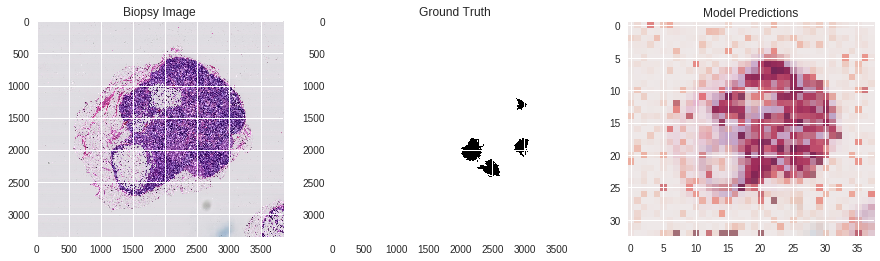

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(131 , title = "Biopsy Image")
plt.imshow(slide_image_test)
plt.subplot(132 , title = "Ground Truth")
plt.imshow(mask_image_test)
plt.subplot(133, title = "Model Predictions")
plt.imshow(im_resize)
plt.imshow(prob, cmap='Reds',alpha=0.5)
plt.show()


### My CNN model with Resnet50 as the Conv Base :



## Using Resnet50 :

In [0]:

conv_base = tf.keras.applications.resnet50.ResNet50(include_top=False, 
                                                    weights='imagenet',
                                                    input_shape=(100,100,3))



conv_base.trainable = False



model = 0

model = tf.keras.Sequential([conv_base, 
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(128, activation='relu'),
#                             tf.keras.layers.Dense(128, activation='relu'),
                            tf.keras.layers.Dense(1, activation='sigmoid')])




model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer = tf.train.AdamOptimizer(),
              metrics=['acc'])

/usr/local/lib/python2.7/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94666752/94653016 [==============================] - 4s 0us/step


In [0]:
model.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Train on 2041 samples, validate on 511 samples
Epoch 1/10
2041/2041 [==============================] - 13s 7ms/step - loss: 0.8653 - acc: 0.9270 - val_loss: 1.4266 - val_acc: 0.9080
Epoch 2/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.7692 - acc: 0.9437 - val_loss: 0.4737 - val_acc: 0.9687
Epoch 3/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.6535 - acc: 0.9505 - val_loss: 0.7257 - val_acc: 0.9511
Epoch 4/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.7230 - acc: 0.9490 - val_loss: 0.3817 - val_acc: 0.9746
Epoch 5/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.6545 - acc: 0.9559 - val_loss: 0.2851 - val_acc: 0.9824
Epoch 6/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.6075 - acc: 0.9593 - val_loss: 0.3491 - val_acc: 0.9765
Epoch 7/10
2041/2041 [==============================] - 7s 3ms/step - loss: 0.4612 - acc: 0.9686 - val_loss: 0.3010 - val_acc: 0.9804
Epoch 8/10
204

## Saving the Model :

In [0]:
model.save_weights("Resnet50_model.h5")

In [0]:
y_pred = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)
y_pred_label = model.predict_classes(X_test)

In [0]:
from sklearn.metrics import accuracy_score

print("Accuracy = " , accuracy_score(y_test, y_pred_label, normalize=True))

('Accuracy = ', 0.9393939393939394)


### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1207
           1       0.33      0.60      0.42        47

   micro avg       0.94      0.94      0.94      1254
   macro avg       0.66      0.77      0.70      1254
weighted avg       0.96      0.94      0.95      1254



### Confusion Matrix :

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_label)


array([[1150,   57],
       [  19,   28]])

In [0]:
y_pred_prob.shape

(1254, 1)

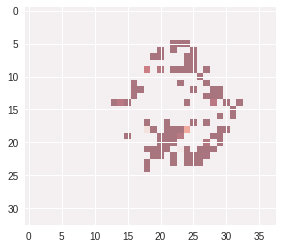

In [0]:
# im = np.reshape(slide_image, (19,16))

prob = np.reshape(y_pred_prob, (-1,38))
#plt.imshow(slide_image)
plt.imshow(prob, cmap='Reds',alpha=0.5)

### Generating Heatmap :

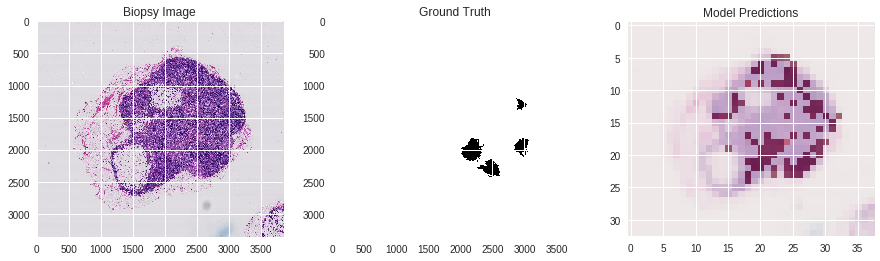

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(131 , title = "Biopsy Image")
plt.imshow(slide_image_test)
plt.subplot(132 , title = "Ground Truth")
plt.imshow(mask_image_test)
plt.subplot(133, title = "Model Predictions")
plt.imshow(im_resize)
plt.imshow(prob, cmap='Reds',alpha=0.5)
plt.show()


### From the above observations we can see that the Resnet50 Model has the highest F1 Score of 95% which is quite good compared to the VGG model (93%) and Inceptionv3 (90%) .
### The Inception V3 model does not seem to be the best model to detect the Cancer Metastatses.

## Testing the Model on a new image using the Save Model:

In [0]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



mask_id_2 = "1oJmDRTE6QJECE6pfGomY4f6GKmVtNQeg"
image_id_2 = "11ZyvVevbY8Ns7z2sD931zM6kz-vCb1av"

image_file_2 = drive.CreateFile({'id': image_id_2})
mask_file_2 = drive.CreateFile({'id': mask_id_2})

image_file_2.GetContentFile("tumor_101.tif")
mask_file_2.GetContentFile("tumor_101_mask.tif")


# file_id = 'REPLACE_WITH_YOUR_FILE_ID'
# downloaded = drive.CreateFile({'id': file_id})
# print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [0]:
slide_path = "tumor_101.tif"
tumor_mask_path = "tumor_101_mask.tif"

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))

print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
#     assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
#     assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Read WSI from tumor_101.tif with width: 139264, height: 71680
Read tumor mask from tumor_101_mask.tif
('Slide includes %d levels', 10)
Level 0, dimensions: (139264, 71680) downsample factor 1
Level 1, dimensions: (69632, 35840) downsample factor 2
Level 2, dimensions: (34816, 17920) downsample factor 4
Level 3, dimensions: (17408, 8960) downsample factor 8
Level 4, dimensions: (8704, 4480) downsample factor 16
Level 5, dimensions: (4352, 2240) downsample factor 32
Level 6, dimensions: (2176, 1120) downsample factor 64
Level 7, dimensions: (1088, 560) downsample factor 128
Level 8, dimensions: (544, 280) downsample factor 256
Level 9, dimensions: (272, 140) downsample factor 512


Read WSI from tumor_101.tif with width: 139264, height: 71680
Read tumor mask from tumor_101_mask.tif


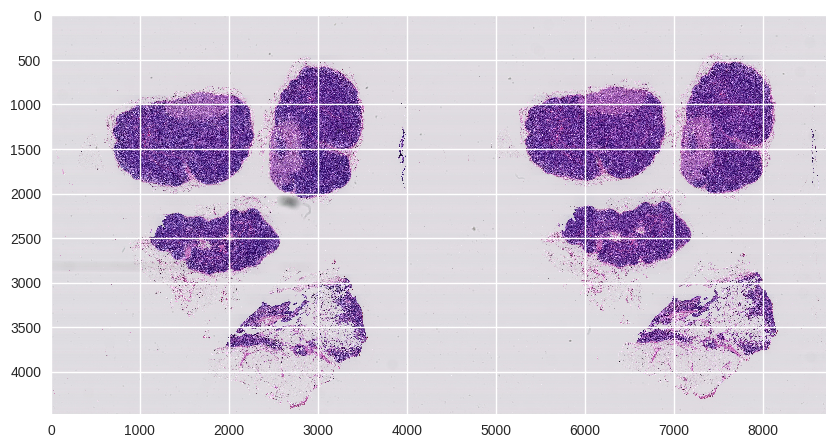

In [0]:
slide_path = 'tumor_101.tif'
tumor_mask_path = 'tumor_101_mask.tif'

slide = open_slide(slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

tumor_mask = open_slide(tumor_mask_path)
print ("Read tumor mask from %s" % (tumor_mask_path))


zoom_level = 4

slide_image_test2 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=zoom_level, 
                         width=slide.level_dimensions[zoom_level][0], 
                         height=slide.level_dimensions[zoom_level][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_test2)

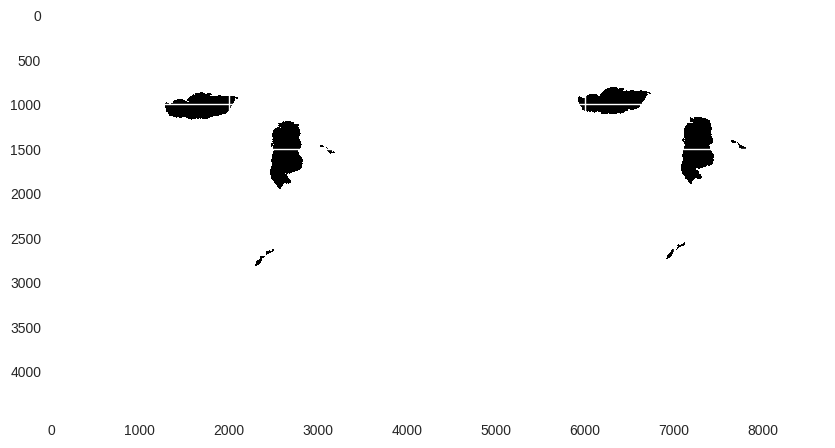

In [0]:
mask_image_test2 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=zoom_level, 
                        width=slide.level_dimensions[zoom_level][0], 
                        height=slide.level_dimensions[zoom_level][1])

# Note: the program provided by the dataset authors generates a mask with R,G,B channels.
# The mask info we need is in the first channel only.
# If you skip this step, the mask will be displayed as all black.
mask_image_test2 = mask_image_test2[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image_test2)

In [0]:
# Split the Big Tiff file into smaller images and labelling each new image

def split_img(slide_image,mask_image):

  split_size = 100
  splitted_images = []
  split_labels = []

  # width , height = slide_image.shape[0] , slide_image.shape[1]


  for i in range(0 , slide_image.shape[0] - split_size + 1, split_size):
    for j in range(0 , slide_image.shape[1] - split_size + 1 , split_size):
      slide_image_splitted = slide_image[i:i + split_size,j : j + split_size,:]
      splitted_images.append(slide_image_splitted)
      split_label = mask_image[i:i+split_size,j : j + split_size].sum()
      if split_label > 0:
        split_labels.append(1)
      else:
        split_labels.append(0)


  splitted_images = np.asarray(splitted_images)
  split_labels = np.asarray(split_labels)
  return splitted_images , split_labels

In [0]:
# Doing the same for the Test Data or Test Image :

X_test , y_test = split_img(slide_image_test2, mask_image_test2)

print(X_test.shape)

print(y_test.shape)

(3828, 100, 100, 3)
(3828,)


In [0]:
!wget https://storage.googleapis.com/deeplearning_rd55031n/resnet_model.h5 -O resnet_model.h5

--2018-12-24 19:15:09--  https://storage.googleapis.com/deeplearning_rd55031n/resnet_model.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111362008 (106M) [application/octet-stream]
Saving to: ‘resnet_model.h5’

resnet_model.h5     100%[===================>] 106.20M  40.5MB/s    in 2.6s    

2018-12-24 19:15:12 (40.5 MB/s) - ‘resnet_model.h5’ saved [111362008/111362008]



In [0]:
ls

adc.json           sample_data/        tumor_101_mask.tif  tumor_110.tif
Resnet50_model.h5  tumor_091_mask.tif  tumor_101.tif       Vgg_model.h5
resnet_model.h5    tumor_091.tif       tumor_110_mask.tif


In [0]:
model.load_weights("resnet_model.h5")

In [0]:
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
              optimizer = tf.train.AdamOptimizer(),
              metrics=['acc'])

In [0]:
y_pred = model.predict(X_test)

y_pred_prob = model.predict_proba(X_test)
y_pred_label = model.predict_classes(X_test)

In [0]:
from sklearn.metrics import accuracy_score

print("Accuracy = " , accuracy_score(y_test, y_pred_label, normalize=True))

('Accuracy = ', 0.9242424242424242)


### Classification Report

In [0]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      3677
           1       0.27      0.53      0.36       151

   micro avg       0.92      0.92      0.92      3828
   macro avg       0.62      0.74      0.66      3828
weighted avg       0.95      0.92      0.94      3828



### Confusion Matrix :

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_label)


array([[3458,  219],
       [  71,   80]])

In [0]:
y_pred_prob.shape

(3828, 1)

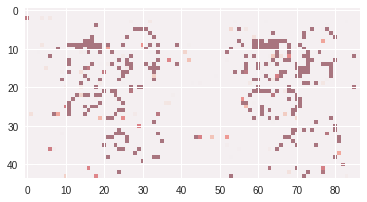

In [0]:
# im = np.reshape(slide_image, (19,16))

prob = np.reshape(y_pred_prob, (-1,87))
#plt.imshow(slide_image)
plt.imshow(prob, cmap='Reds',alpha=0.5)

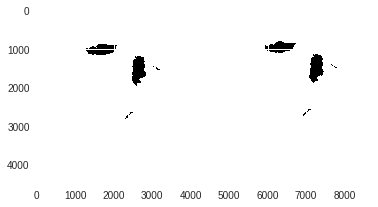

In [0]:
plt.imshow(mask_image_test2)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


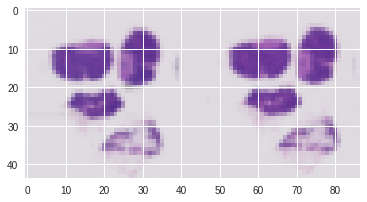

In [0]:
from scipy.misc import imresize

# from skimage.transform import resize
im_resize = imresize(slide_image_test2, 0.01 , mode='RGB')
plt.imshow(im_resize)

### Generating Heatmap :

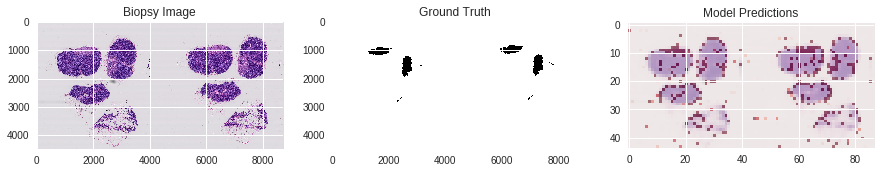

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,15))
plt.subplot(131 , title = "Biopsy Image")
plt.imshow(slide_image_test2)
plt.subplot(132 , title = "Ground Truth")
plt.imshow(mask_image_test2)
plt.subplot(133, title = "Model Predictions")
plt.imshow(im_resize)
plt.imshow(prob, cmap='Reds',alpha=0.5)
plt.show()


## Thank You